<a href="https://colab.research.google.com/github/ixvqc/praca-magisterska/blob/main/CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


--- Metryki Oceny dla Bazowego Modelu CatBoost ---

Macierz pomyłek (Test):
[[942  93]
 [183 191]]
  Prawdziwie Pozytywne (TP) (churn): 191
  Fałszywie Pozytywne (FP) (churn): 93
  Prawdziwie Negatywne (TN) (non-churn): 942
  Fałszywie Negatywne (FN) (churn): 183

Accuracy: 0.8041

Recall: 0.5107

Precision: 0.6725

F1-score: 0.5805

AUROC: 0.8482



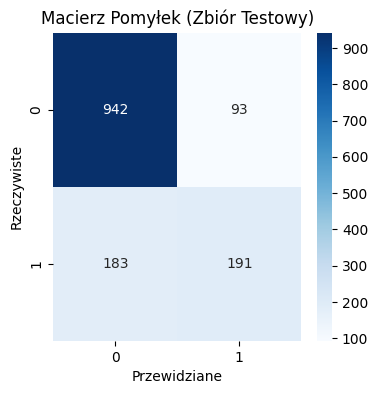

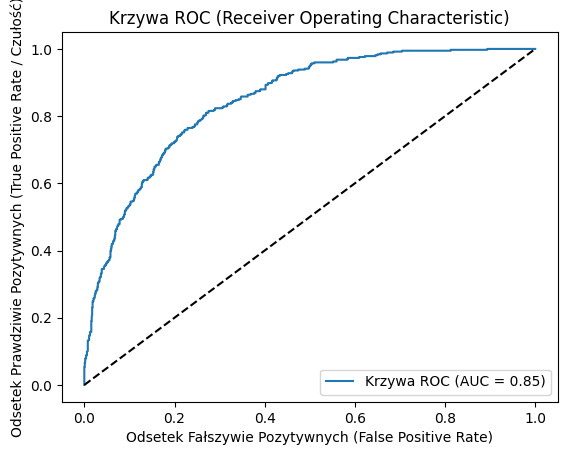

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:71: FutureWarning: `fit_params` is deprecated and will be removed in version {version}. Pass parameters via `params` instead.
  warnings.warn(


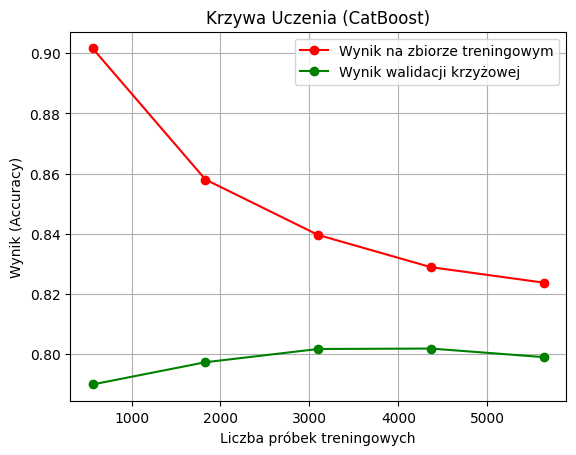

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve # Dodano learning_curve
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, roc_curve, auc
) # Usunięto nieużywane metryki z importu
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Wczytaj dane
df = pd.read_csv("/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])
if df['TotalCharges'].dtype == object:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# 2. Lista cech kategorycznych (nazwy kolumn)
cat_cols_names = df.select_dtypes(include=['object']).columns.tolist()
cat_cols_names = [col for col in cat_cols_names if col != 'Churn']

# 3. Kodowanie targetu
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# 4. Podział na X i y
X = df.drop(columns=['Churn'])
y = df['Churn']

# Uzyskanie indeksów cech kategorycznych
cat_features_indices = [X.columns.get_loc(col) for col in cat_cols_names]

# 5. Podział na train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Trening
model_catboost = CatBoostClassifier(
    iterations=300,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    eval_metric='AUC',
    verbose=0
)
model_catboost.fit(X_train, y_train, cat_features=cat_features_indices, eval_set=(X_test, y_test))

# 7. Ewaluacja na zbiorze testowym
y_pred = model_catboost.predict(X_test)
y_pred = y_pred.astype(int)
y_proba = model_catboost.predict_proba(X_test)[:, 1]


# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print("\nMacierz pomyłek (Test):")
print(cm)
print(f"  Prawdziwie Pozytywne (TP) (churn): {tp}")
print(f"  Fałszywie Pozytywne (FP) (churn): {fp}")
print(f"  Prawdziwie Negatywne (TN) (non-churn): {tn}")
print(f"  Fałszywie Negatywne (FN) (churn): {fn}\n")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

# Recall
recall_churn = tp / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Recall: {recall_churn:.4f}\n")

# Precision
precision_churn = tp / (tp + fp) if (tp + fp) > 0 else 0.0
print(f"Precision: {precision_churn:.4f}\n")

# F1-score
if (precision_churn + recall_churn) > 0:
    f1_churn = 2 * (precision_churn * recall_churn) / (precision_churn + recall_churn)
else:
    f1_churn = 0.0
print(f"F1-score: {f1_churn:.4f}\n")

# AUROC
auroc = roc_auc_score(y_test, y_proba)
print(f"AUROC: {auroc:.4f}\n")

# Strategia walidacji krzyżowej (dla krzywej uczenia)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



# Wykres: Macierz pomyłek (Zbiór Testowy)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz Pomyłek (Zbiór Testowy)')
plt.show()

# Wykres: Krzywa ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
roc_auc_value = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Krzywa ROC (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Odsetek Fałszywie Pozytywnych (False Positive Rate)')
plt.ylabel('Odsetek Prawdziwie Pozytywnych (True Positive Rate / Czułość)')
plt.title('Krzywa ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()


# Wykres: Krzywa Uczenia
from sklearn.base import clone
estimator_for_lc = clone(model_catboost)

train_sizes_abs, train_scores, test_scores_lc = learning_curve(
    estimator=estimator_for_lc,
    X=X, # Pełen zbiór X
    y=y, # Pełen zbiór y
    cv=cv_strategy,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
    fit_params={'cat_features': cat_features_indices}
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores_lc, axis=1)

plt.figure()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label='Wynik na zbiorze treningowym')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label='Wynik walidacji krzyżowej')
plt.xlabel('Liczba próbek treningowych')
plt.ylabel('Wynik (Accuracy)')
plt.title('Krzywa Uczenia (CatBoost)')
plt.legend(loc='best')
plt.grid()
plt.show()


Używam class_weights = [1.0, 2.768561872909699]
Macierz pomyłek (Test):
[[755 280]
 [ 73 301]]
  Prawdziwie Pozytywne (TP) (churn): 301
  Fałszywie Pozytywne (FP) (churn): 280
  Prawdziwie Negatywne (TN) (non-churn): 755
  Fałszywie Negatywne (FN) (churn): 73
Accuracy: 0.7495
Recall: 0.8048
Precision: 0.5181
F1-score: 0.6304
AUROC: 0.8461


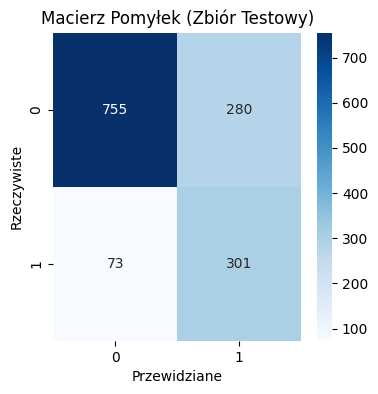

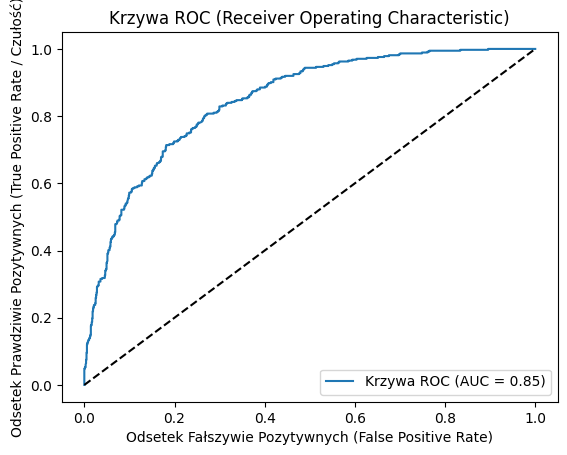

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:71: FutureWarning: `fit_params` is deprecated and will be removed in version {version}. Pass parameters via `params` instead.
  warnings.warn(


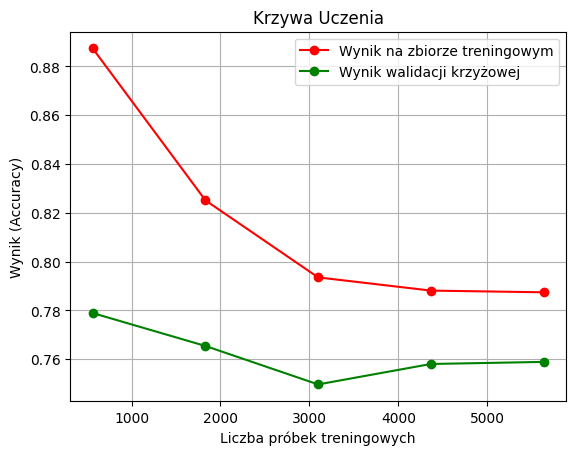

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, roc_curve, auc
)
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Wczytaj dane
df = pd.read_csv("/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])
if df['TotalCharges'].dtype == object:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# 2. Lista cech kategorycznych
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in cat_cols if col != 'Churn']

# 3. Kodowanie targetu
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# 4. Podział na X i y
X = df.drop(columns=['Churn'])
y = df['Churn']
cat_features = [X.columns.get_loc(col) for col in cat_cols]

# 5. Podział na train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Wylicz wagi klas
n_class_0 = sum(y_train == 0)
n_class_1 = sum(y_train == 1)
class_weights = [1.0, n_class_0 / n_class_1]
print(f"Używam class_weights = {class_weights}")

# 7. Trening
model = CatBoostClassifier(
    iterations=300,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    eval_metric='AUC',
    class_weights=class_weights,
    verbose=0
)
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

# 8. Ewaluacja na zbiorze testowym
y_pred = model.predict(X_test).astype(int)
y_proba = model.predict_proba(X_test)[:, 1]


# Macierz pomyłek (oraz TP, FP, TN, FN)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print("Macierz pomyłek (Test):")
print(cm)
print(f"  Prawdziwie Pozytywne (TP) (churn): {tp}")
print(f"  Fałszywie Pozytywne (FP) (churn): {fp}")
print(f"  Prawdziwie Negatywne (TN) (non-churn): {tn}")
print(f"  Fałszywie Negatywne (FN) (churn): {fn}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Recall
recall_churn = tp / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Recall: {recall_churn:.4f}")

# Precision
precision_churn = tp / (tp + fp) if (tp + fp) > 0 else 0.0
print(f"Precision: {precision_churn:.4f}")

# F1-score
if (precision_churn + recall_churn) > 0:
    f1_churn = 2 * (precision_churn * recall_churn) / (precision_churn + recall_churn)
else:
    f1_churn = 0.0
print(f"F1-score: {f1_churn:.4f}")

# AUROC
auroc = roc_auc_score(y_test, y_proba)
print(f"AUROC: {auroc:.4f}")

# --- Wykresy ---

# Wykres: Macierz pomyłek (Test)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz Pomyłek (Zbiór Testowy)')
plt.show()

# Wykres: Krzywa ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
roc_auc_value = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Krzywa ROC (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Odsetek Fałszywie Pozytywnych (False Positive Rate)')
plt.ylabel('Odsetek Prawdziwie Pozytywnych (True Positive Rate / Czułość)')
plt.title('Krzywa ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

# Wykres: Krzywa Uczenia
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
from sklearn.base import clone
train_sizes_abs, train_scores, test_scores_lc = learning_curve(
    estimator=clone(model),
    X=X,
    y=y,
    cv=cv_strategy,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
    fit_params={'cat_features': cat_features}
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores_lc, axis=1)

plt.figure()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label='Wynik na zbiorze treningowym')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label='Wynik walidacji krzyżowej')
plt.xlabel('Liczba próbek treningowych')
plt.ylabel('Wynik (Accuracy)')
plt.title('Krzywa Uczenia')
plt.legend(loc='best')
plt.grid()
plt.show()

Macierz pomyłek (Test):
[[856 179]
 [124 250]]
  Prawdziwie Pozytywne (TP) (churn): 250
  Fałszywie Pozytywne (FP) (churn): 179
  Prawdziwie Negatywne (TN) (non-churn): 856
  Fałszywie Negatywne (FN) (churn): 124
Accuracy: 0.7850
Recall: 0.6684
Precision: 0.5828
F1-score: 0.6227
AUROC: 0.8406


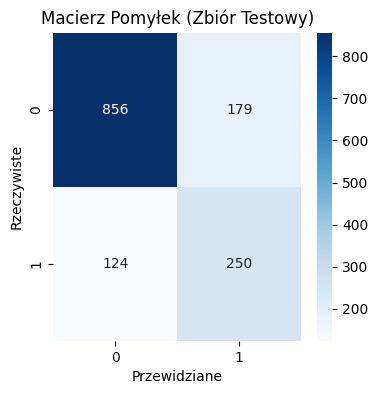

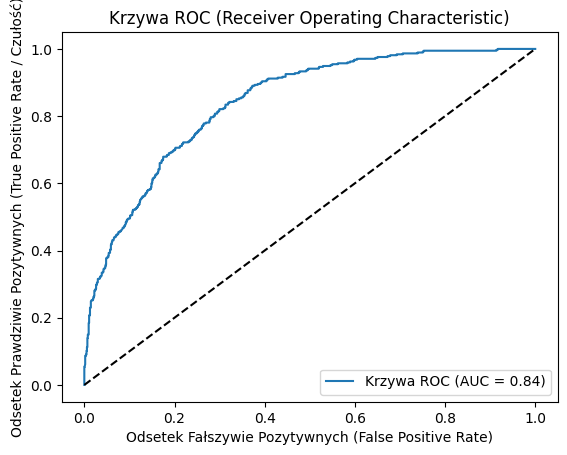

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:71: FutureWarning: `fit_params` is deprecated and will be removed in version {version}. Pass parameters via `params` instead.
  warnings.warn(


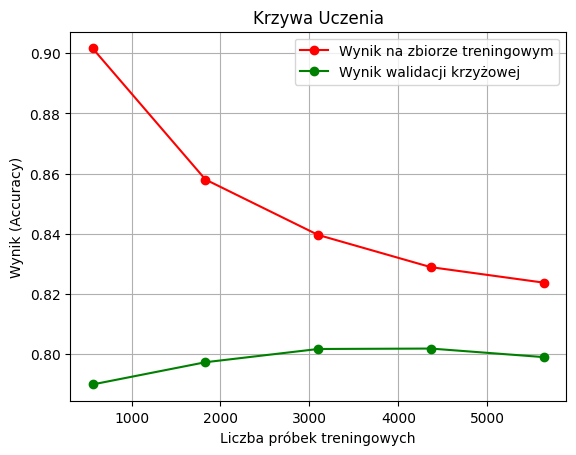

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, roc_curve, auc
)
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Wczytaj dane
df = pd.read_csv("/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])
if df['TotalCharges'].dtype == object:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# 2. Lista cech kategorycznych
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in cat_cols if col != 'Churn']

# 3. Kodowanie targetu
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# 4. Podział na X i y
X = df.drop(columns=['Churn'])
y = df['Churn']
cat_features = [X.columns.get_loc(col) for col in cat_cols]

# 5. Podział na train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. SMOTE na danych treningowych
X_train_smote = X_train.copy()
X_test_cat = X_test.copy()
cat_maps = {}

for col in cat_cols:
    X_train_smote[col], cat_maps[col] = X_train_smote[col].factorize(sort=True)
    X_test_cat[col] = X_test_cat[col].map({cat: i for i, cat in enumerate(cat_maps[col])})

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_smote, y_train)
X_res = pd.DataFrame(X_res, columns=X_train_smote.columns)

for idx, col in enumerate(cat_cols):
    labels = cat_maps[col]
    def to_label(x):
        try:
            return labels[int(x)]
        except (ValueError, TypeError):
            return x
    X_res[col] = [to_label(i) for i in X_res[col]]
    X_test_cat[col] = X_test_cat[col].map(lambda x: labels[x] if pd.notnull(x) and isinstance(x, (int, np.integer)) and x < len(labels) else x)
    X_res[col] = X_res[col].astype(str)
    X_test_cat[col] = X_test_cat[col].astype(str)

cat_features_res = [X_res.columns.get_loc(col) for col in cat_cols]

# 7. Trening
model = CatBoostClassifier(
    iterations=300,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    eval_metric='AUC',
    verbose=0
)
model.fit(X_res, y_res, cat_features=cat_features_res, eval_set=(X_test_cat, y_test))

# 8. Ewaluacja na test secie
y_pred = model.predict(X_test_cat).astype(int)
y_proba = model.predict_proba(X_test_cat)[:, 1]


# Macierz pomyłek (oraz TP, FP, TN, FN)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print("Macierz pomyłek (Test):")
print(cm)
print(f"  Prawdziwie Pozytywne (TP) (churn): {tp}")
print(f"  Fałszywie Pozytywne (FP) (churn): {fp}")
print(f"  Prawdziwie Negatywne (TN) (non-churn): {tn}")
print(f"  Fałszywie Negatywne (FN) (churn): {fn}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Recall
recall_churn = tp / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"Recall: {recall_churn:.4f}")

# Precision
precision_churn = tp / (tp + fp) if (tp + fp) > 0 else 0.0
print(f"Precision: {precision_churn:.4f}")

# F1-score
if (precision_churn + recall_churn) > 0:
    f1_churn = 2 * (precision_churn * recall_churn) / (precision_churn + recall_churn)
else:
    f1_churn = 0.0
print(f"F1-score: {f1_churn:.4f}")

# AUROC
auroc = roc_auc_score(y_test, y_proba)
print(f"AUROC: {auroc:.4f}")

# --- Wykresy ---

# Wykres: Macierz pomyłek (Test)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz Pomyłek (Zbiór Testowy)')
plt.show()

# Wykres: Krzywa ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
roc_auc_value = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Krzywa ROC (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Odsetek Fałszywie Pozytywnych (False Positive Rate)')
plt.ylabel('Odsetek Prawdziwie Pozytywnych (True Positive Rate / Czułość)')
plt.title('Krzywa ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

# Wykres: Krzywa Uczenia
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
from sklearn.base import clone
train_sizes_abs, train_scores, test_scores_lc = learning_curve(
    estimator=clone(model),
    X=X,
    y=y,
    cv=cv_strategy,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
    fit_params={'cat_features': cat_features}
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores_lc, axis=1)

plt.figure()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label='Wynik na zbiorze treningowym')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label='Wynik walidacji krzyżowej')
plt.xlabel('Liczba próbek treningowych')
plt.ylabel('Wynik (Accuracy)')
plt.title('Krzywa Uczenia')
plt.legend(loc='best')
plt.grid()
plt.show()